In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "worldbank_data_exploration"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
# %matplotlib widget # uncomment for interactive plots (smaller figsize and textsize advised)

import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import (
    TSNE,
    MDS,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from umap import UMAP

from data_sources.load_dataset import load_time_series, INDICATORS_SELECTED, INDICATORS_AGRICULTURE, INDICATORS_HEALTH, INDICATORS_ECONOMY, ALL_INDICATORS

from feature_extraction import AutoencoderExtractor

C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (C:\\Users\\MatiX\\anaconda3\\envs\\py39\\lib\\site-packages\\urllib3\\util\\__init__.py)', 'urllib3.util.ssl_ (C:\\Users\\MatiX\\anaconda3\\envs\\py39\\lib\\site-packages\\urllib3\\util\\ssl_.py)']. 
  curious_george.patch_all(thread=False, select=False)


# Utils

In [3]:
def plot_normal(X, y, legend=False):
    plt.figure(figsize=(8, 8))
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], label=y[i])

    if legend:
        plt.legend()
    plt.show()


def plot_with_names(
    X,
    y,
    specific_list=[
        [
            "Poland",
            "Germany",
            "Czech Republic",
            "Slovak Republic",
            "France",
            "United Kingdom",
        ],
        ["United States", "China", "Singapore"],
        ["Kenya", "Madagascar", "Nigeria"],
        ["Ukraine", "Belarus"],
        ["Latvia", "Estonia", "Lithuania"],
    ],
    title=None,
    figsize=(16, 16),
    # figsize=(8, 8),
    textsize=7.5
    # textsize=6,
):
    plt.figure(figsize=figsize)

    mask = np.in1d(y, np.array(specific_list).flatten())
    plt.scatter(X[np.logical_not(mask)][:, 0], X[np.logical_not(mask)][:, 1])
    for specific in specific_list:
        mask = np.in1d(y, specific)
        plt.scatter(X[mask][:, 0], X[mask][:, 1])

    for i in range(X.shape[0]):
        plt.annotate(y[i], [X[i, 0], X[i, 1]], size=textsize)

    if title is not None:
        plt.title(title)
    plt.show()


def extract_from_all(extractor_fun, time_series_dict):
    if extractor_fun("all") is None:
        return np.hstack(list(time_series_dict.values()))
    else:
        Y_all = []
        for feature, X in time_series_dict.items():
            extractor = extractor_fun(feature)
            Y_feature = extractor.extract_features(X)
            Y_all.append(Y_feature)

        return np.hstack(Y_all)
    
def process_group(time_series_dict):
    for extractor_fun in EXTRACTORS:
        print("-----------------------------------------")
        print("-----------------------------------------")
        extractor_title = (
            "No extraction"
            if extractor_fun("all") is None
            else f"Autoencoder, n_bottleneck={extractor_fun('all').autoencoder.n_bottleneck})"
        )
        print(extractor_title)
        print("-----------------------------------------")

        for alg, alg_args in zip(ALGS, ALG_ARGS):
            Y = extract_from_all(extractor_fun, time_series_dict)

            Y_projected = alg(**alg_args).fit_transform(Y)
            title = f"{extractor_title}, {alg.__name__}, {alg_args}"
            plot_with_names(Y_projected, countries, title=title)

# Config

In [4]:
INPUT_LEN = 19

EXTRACTORS = [
    # lambda f: None,
    # lambda f: AutoencoderExtractor(n_bottleneck=2, feature=f, root=pwd, input_len=INPUT_LEN),
    # lambda f: AutoencoderExtractor( # use the network trained for all series
    #     n_bottleneck=4, feature="all", root=pwd, input_len=INPUT_LEN
    # ),
    lambda f: AutoencoderExtractor(
        n_bottleneck=4, feature=f, root=pwd, input_len=INPUT_LEN
    ),
    # lambda f: AutoencoderExtractor(n_bottleneck=8, feature=f, root=pwd, input_len=INPUT_LEN)
]

ALGS = [
    TSNE,
    # MDS,
    UMAP,
    UMAP,
]
ALG_ARGS = [
    {"n_components": 2, "perplexity": 15, "n_iter": 4000},
    # {'n_components': 2},
    {
        "n_components": 2,
        "n_neighbors": 6,
        "min_dist": 0.1,
        "metric": "correlation",
        "n_epochs": 2000,
    },
    {
        "n_components": 2,
        "n_neighbors": 6,
        "min_dist": 0.4,
        "metric": "correlation",
        "n_epochs": 2000,
    },
]

# Selected indicators

In [5]:
time_series_dict, countries, years = load_time_series(indicators=INDICATORS_SELECTED)

time_series_dict.keys()

dict_keys(['Access to electricity (% of population)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'Life expectancy at birth, total (years)', 'Merchandise trade (% of GDP)', 'Military expenditure (% of GDP)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Population in the largest city (% of urban population)', 'Total natural resources rents (% of GDP)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)'])

-----------------------------------------
-----------------------------------------
Autoencoder, n_bottleneck=4)
-----------------------------------------


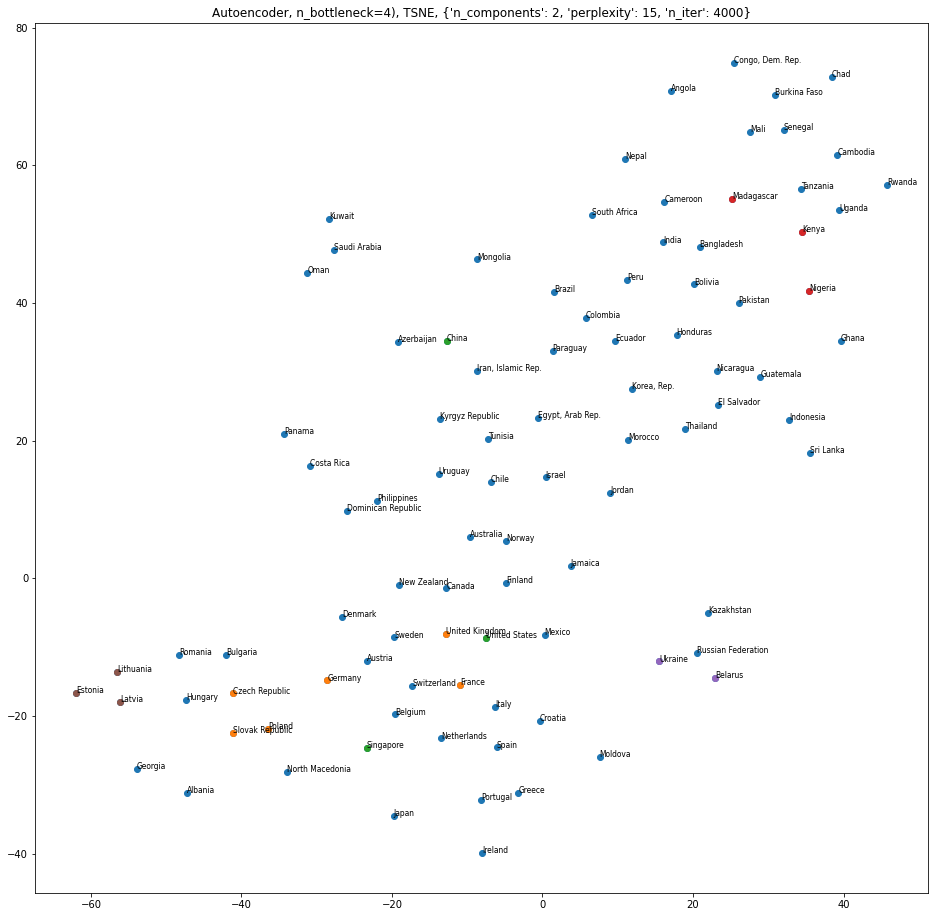

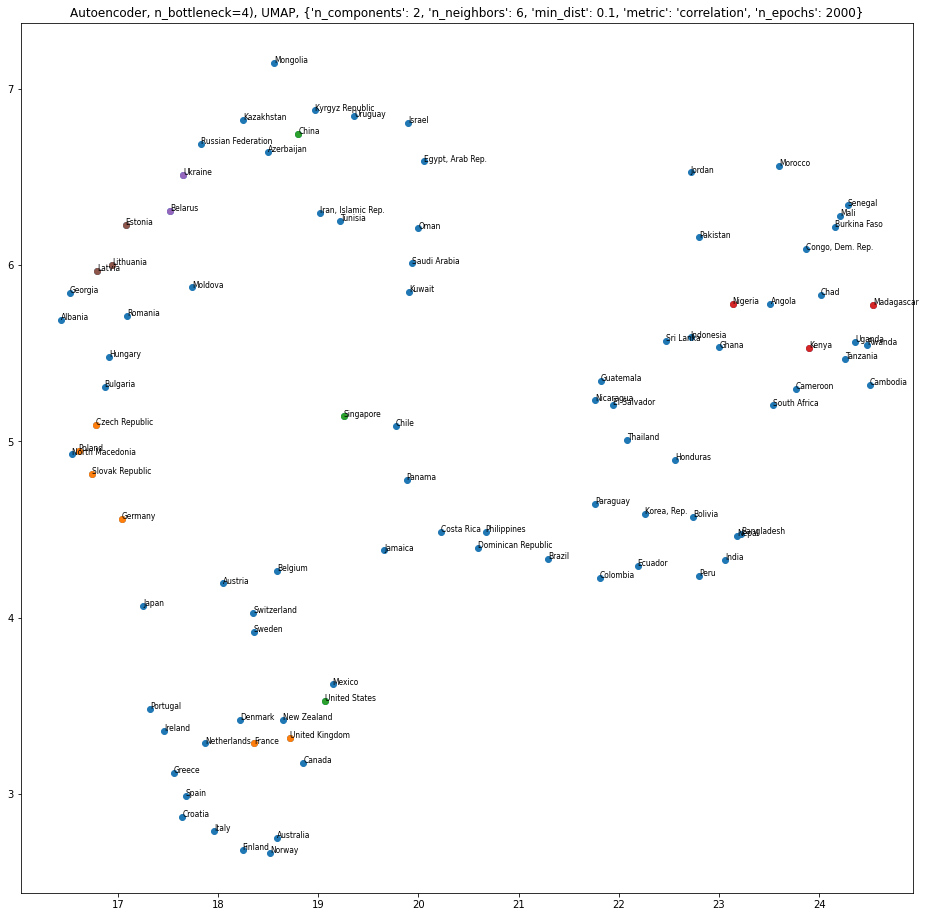

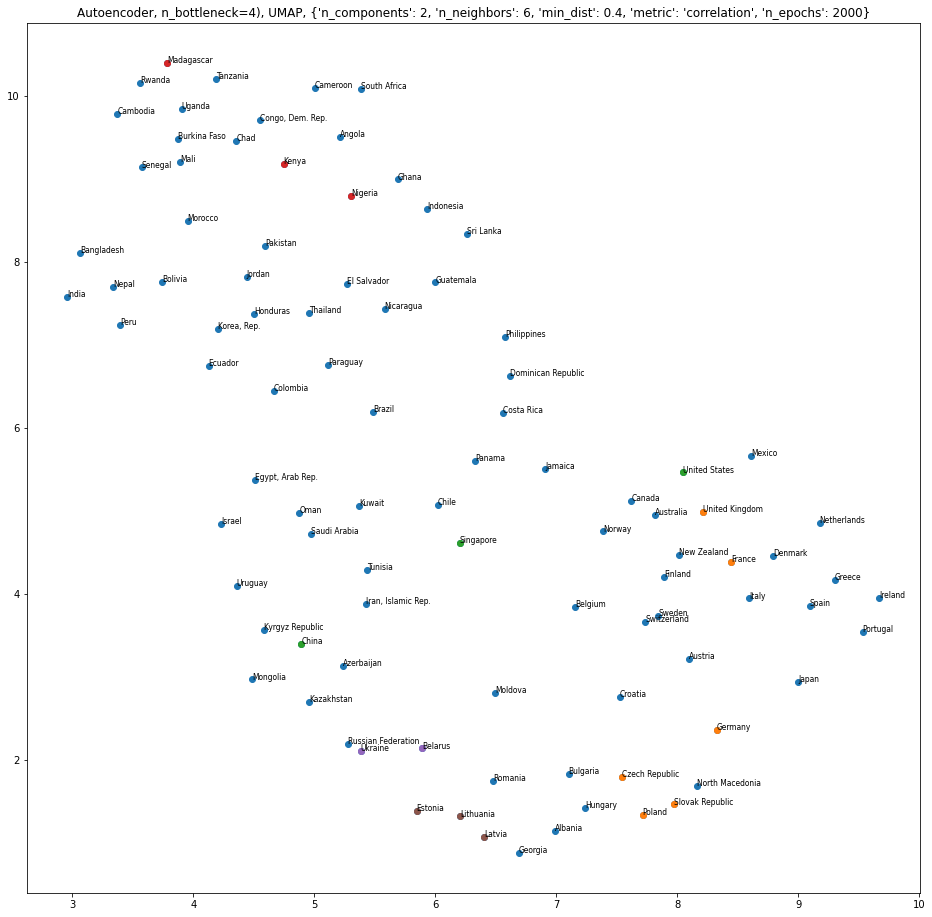

In [6]:
process_group(time_series_dict)

# Agriculture

In [7]:
time_series_dict, countries, years = load_time_series(indicators=INDICATORS_AGRICULTURE)

time_series_dict.keys()

dict_keys(['Agricultural land (% of land area)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Arable land (% of land area)', 'Arable land (hectares per person)', 'Cereal yield (kg per hectare)', 'Crop production index (2014-2016 = 100)', 'Employment in agriculture, female (% of female employment) (modeled ILO estimate)', 'Employment in agriculture, male (% of male employment) (modeled ILO estimate)', 'Fertilizer consumption (kilograms per hectare of arable land)', 'Food production index (2014-2016 = 100)', 'Forest area (% of land area)', 'Livestock production index (2014-2016 = 100)', 'Permanent cropland (% of land area)', 'Rural population (% of total population)'])

-----------------------------------------
-----------------------------------------
Autoencoder, n_bottleneck=4)
-----------------------------------------


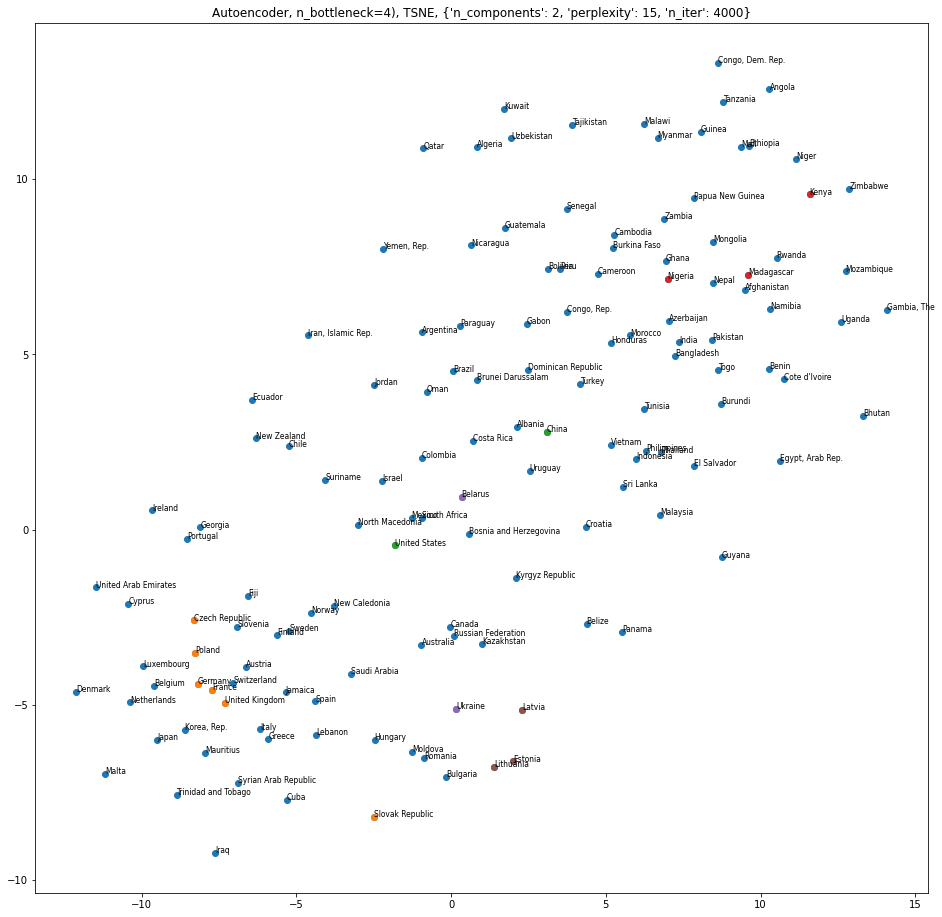

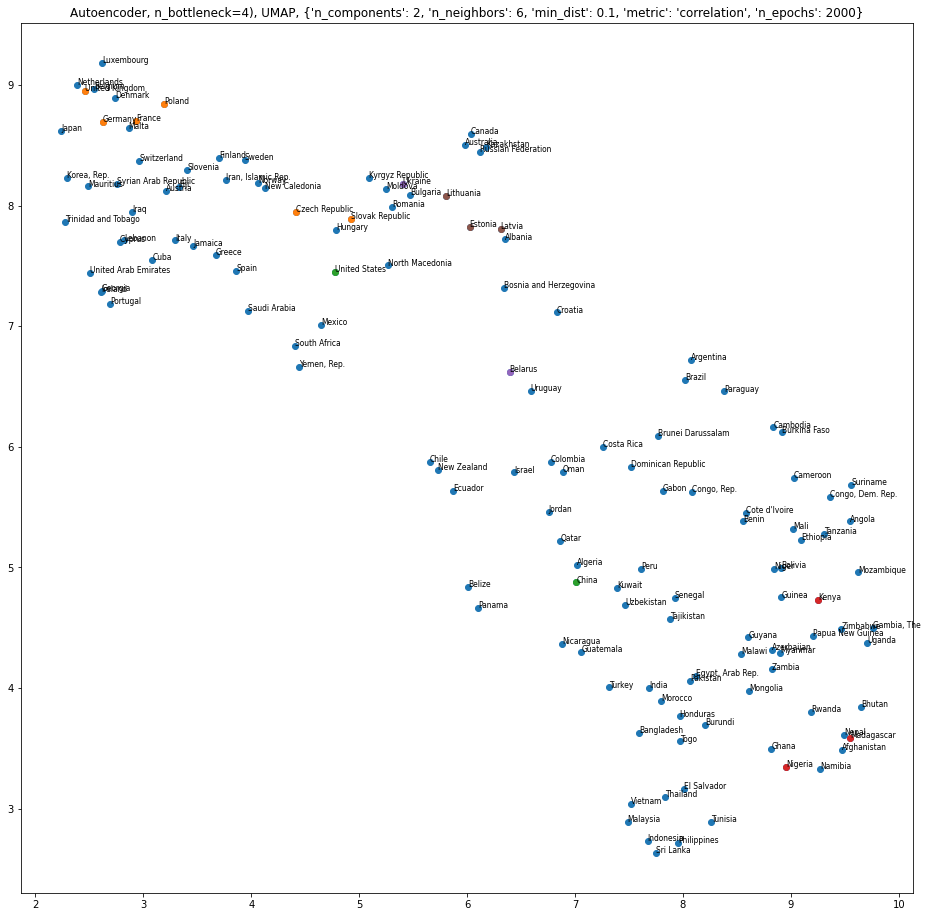

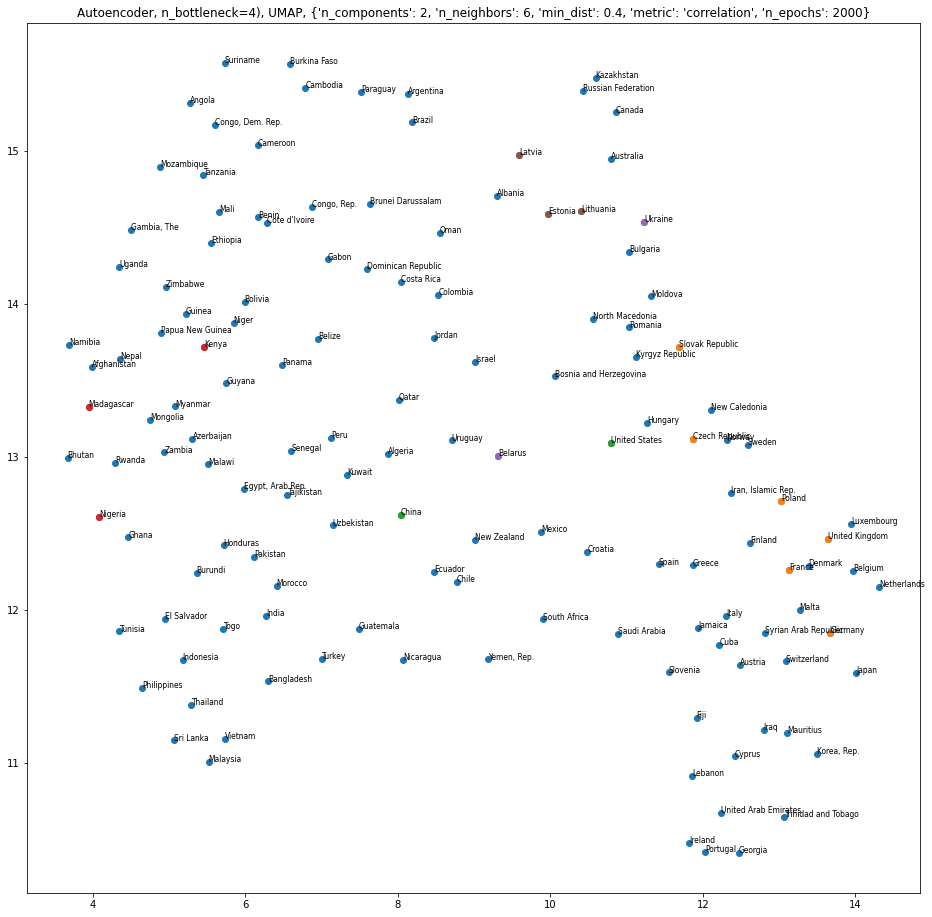

In [8]:
process_group(time_series_dict)

# Health

In [9]:
time_series_dict, countries, years = load_time_series(indicators=INDICATORS_HEALTH)

time_series_dict.keys()

dict_keys(['Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Age dependency ratio (% of working-age population)', 'Birth rate, crude (per 1,000 people)', 'Death rate, crude (per 1,000 people)', 'Fertility rate, total (births per woman)', 'Immunization, DPT (% of children ages 12-23 months)', 'Immunization, measles (% of children ages 12-23 months)', 'Incidence of tuberculosis (per 100,000 people)', 'Life expectancy at birth, total (years)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Prevalence of undernourishment (% of population)'])

-----------------------------------------
-----------------------------------------
Autoencoder, n_bottleneck=4)
-----------------------------------------


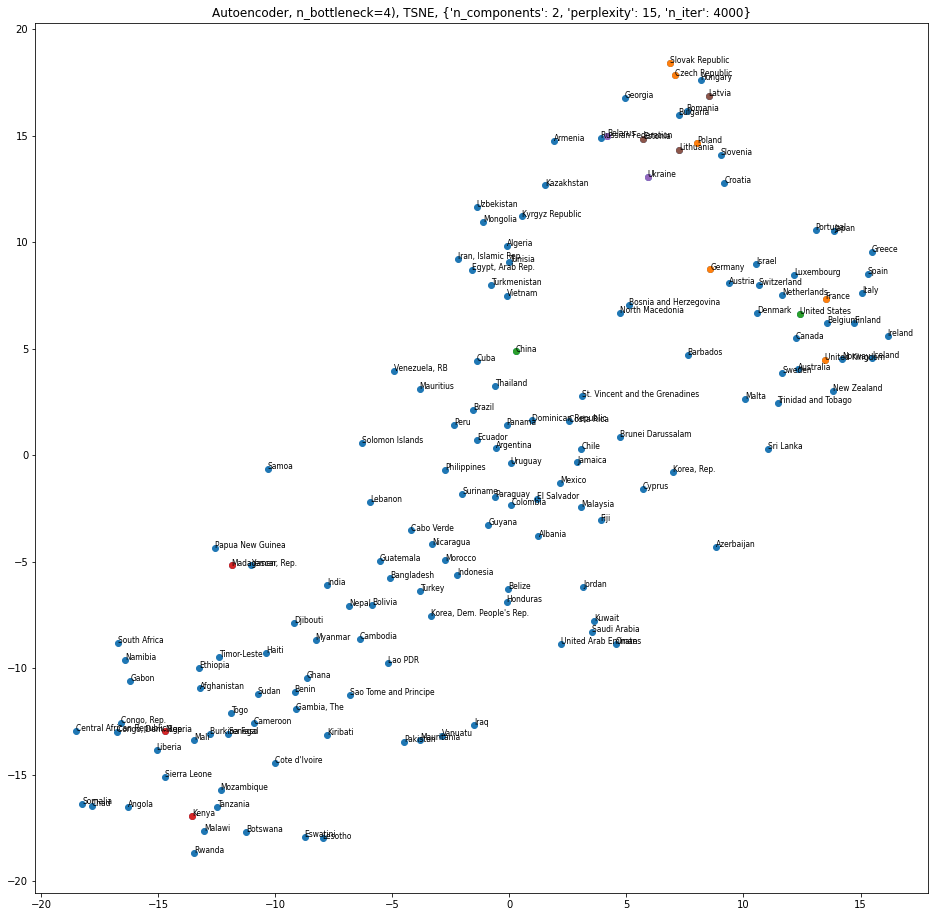

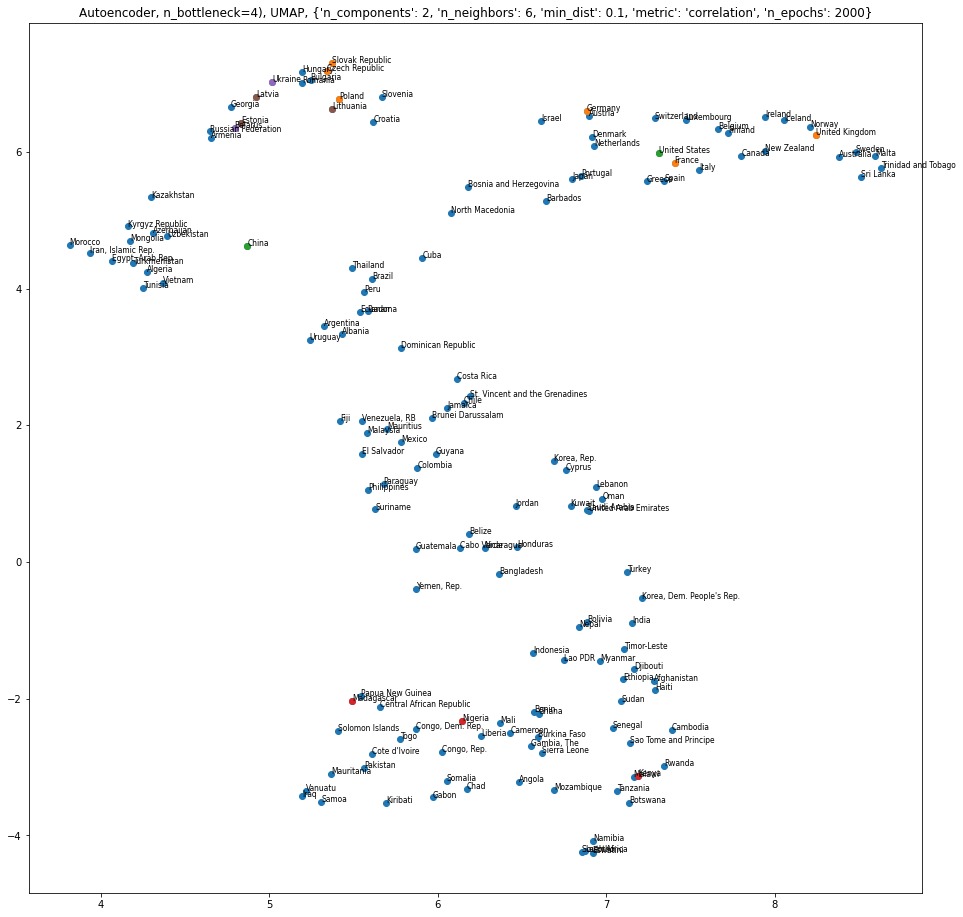

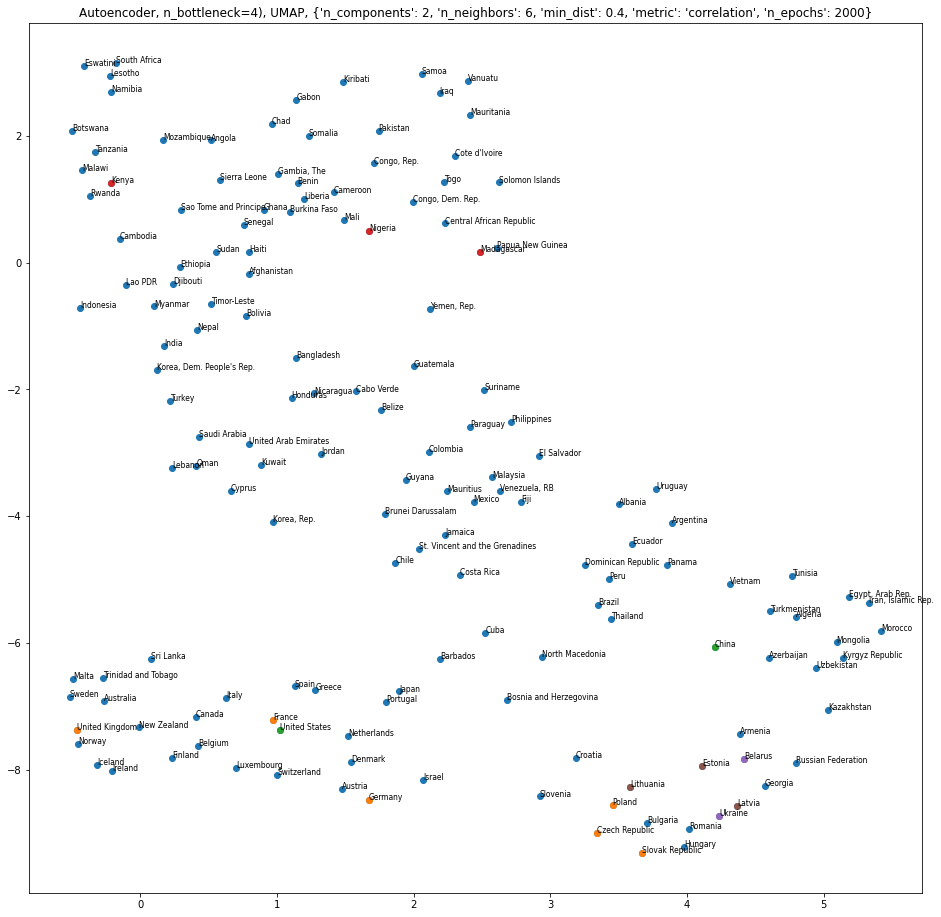

In [10]:
process_group(time_series_dict)

# Economy

In [11]:
time_series_dict, countries, years = load_time_series(indicators=INDICATORS_ECONOMY)

time_series_dict.keys()

dict_keys(['Agriculture, forestry, and fishing, value added (% of GDP)', 'Exports of goods and services (% of GDP)', 'GDP growth (annual %)', 'GDP per capita (current US$)', 'GNI per capita, Atlas method (current US$)', 'Gross capital formation (% of GDP)', 'Gross savings (% of GDP)', 'Imports of goods and services (% of GDP)', 'Industry (including construction), value added (% of GDP)', 'Inflation, GDP deflator (annual %)', 'Inflation, consumer prices (annual %)', 'Medium and high-tech manufacturing value added (% manufacturing value added)'])

-----------------------------------------
-----------------------------------------
Autoencoder, n_bottleneck=4)
-----------------------------------------


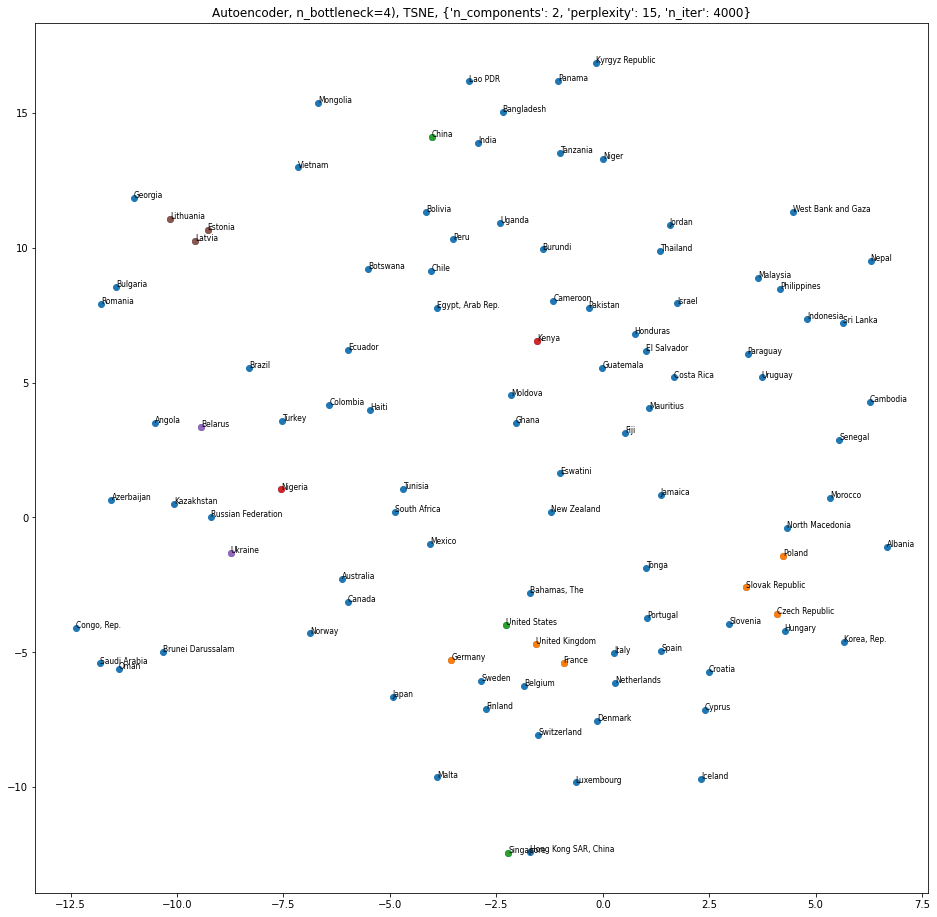

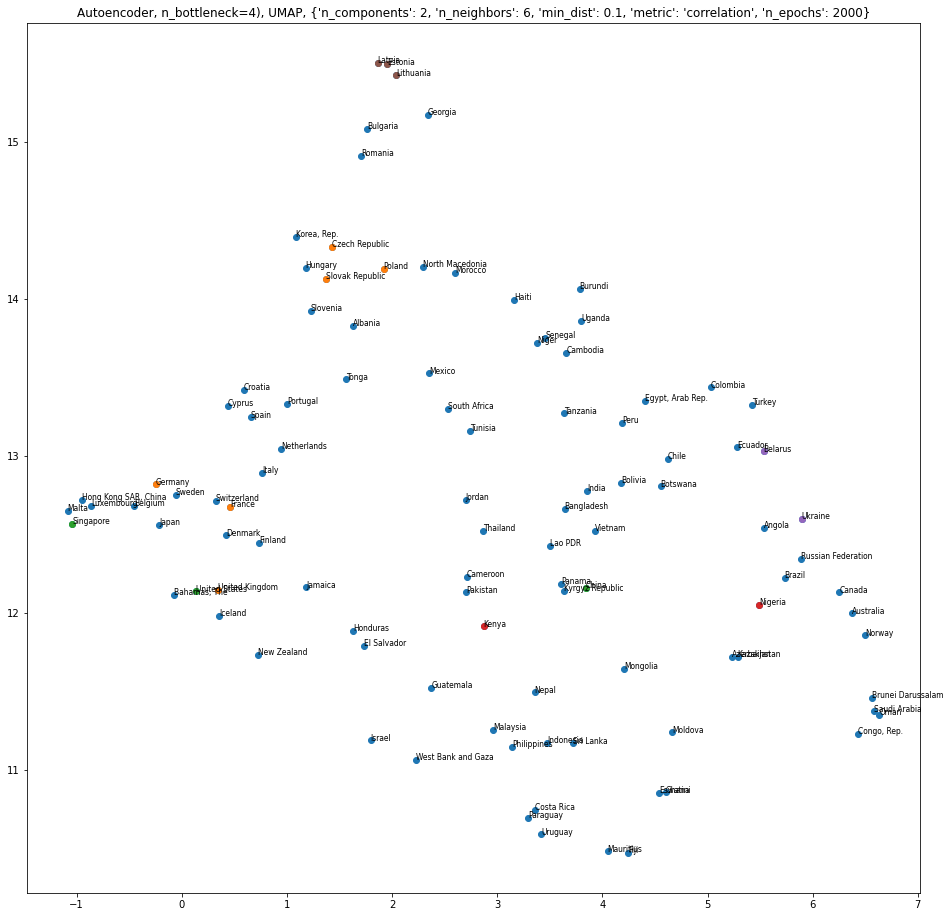

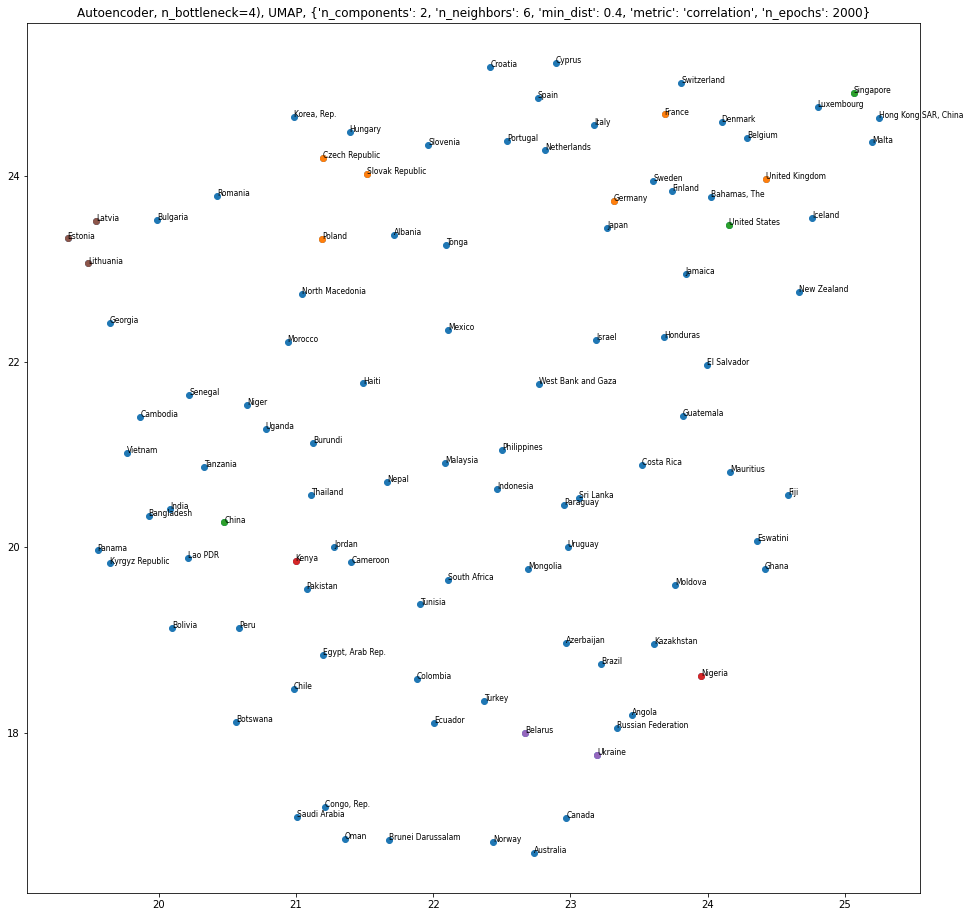

In [12]:
process_group(time_series_dict)

# All indicators

In [13]:
time_series_dict, countries, years = load_time_series(indicators=ALL_INDICATORS)

time_series_dict.keys()

dict_keys(['Access to electricity (% of population)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Age dependency ratio (% of working-age population)', 'Agricultural land (% of land area)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Arable land (% of land area)', 'Arable land (hectares per person)', 'Birth rate, crude (per 1,000 people)', 'Cereal yield (kg per hectare)', 'Crop production index (2014-2016 = 100)', 'Death rate, crude (per 1,000 people)', 'Employment in agriculture, female (% of female employment) (modeled ILO estimate)', 'Employment in agriculture, male (% of male employment) (modeled ILO estimate)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Fertilizer consumption (kilograms per hectare of arable land)', 'Food production index (2014-2016 = 100)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'GDP per capita (current US$)', 'GNI per capita, Atlas method (current US$)', 'Gros

-----------------------------------------
-----------------------------------------
Autoencoder, n_bottleneck=4)
-----------------------------------------


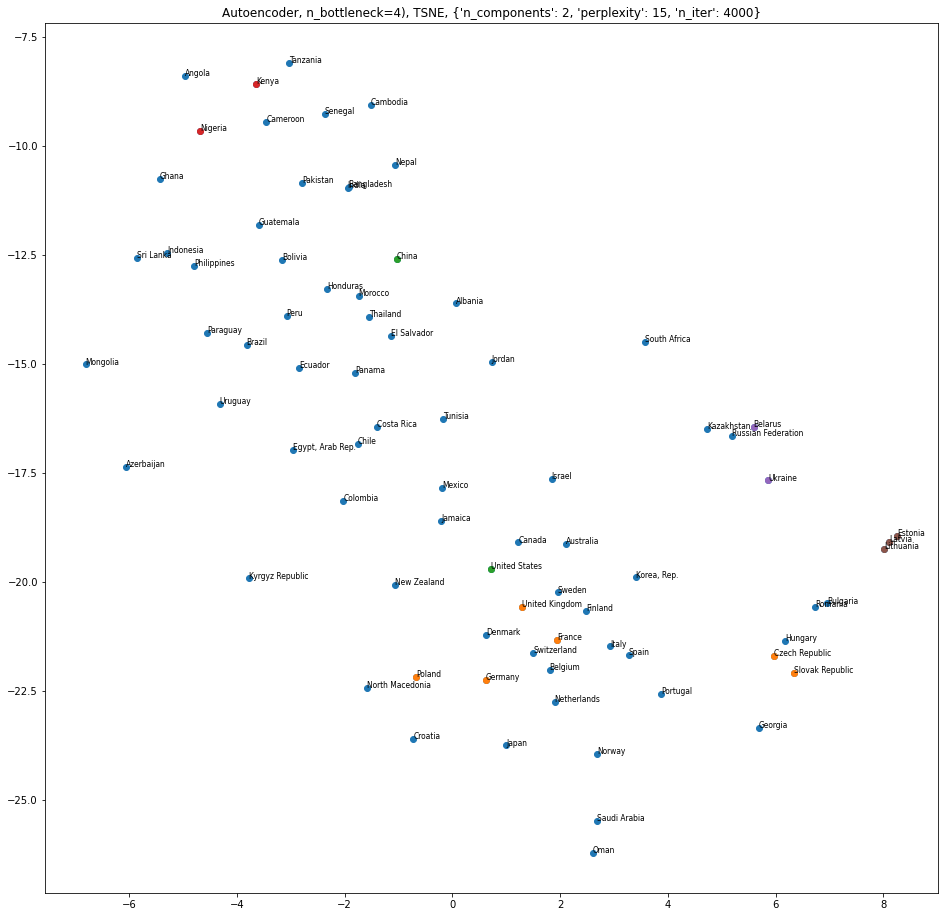

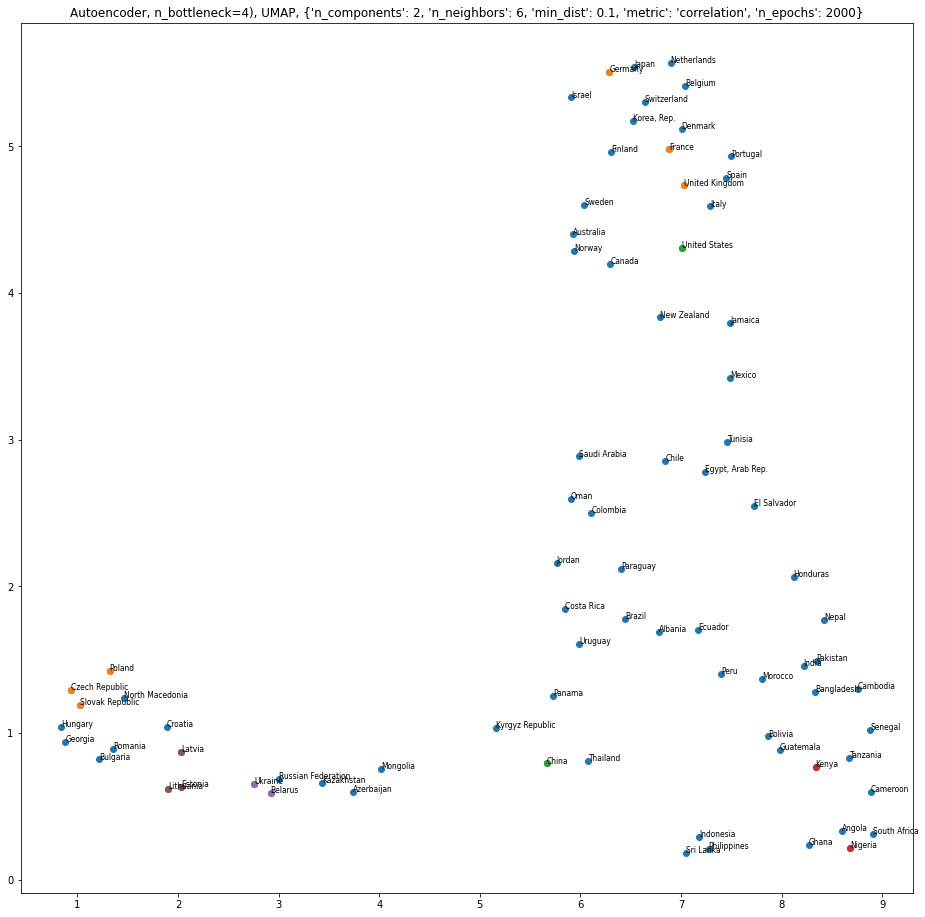

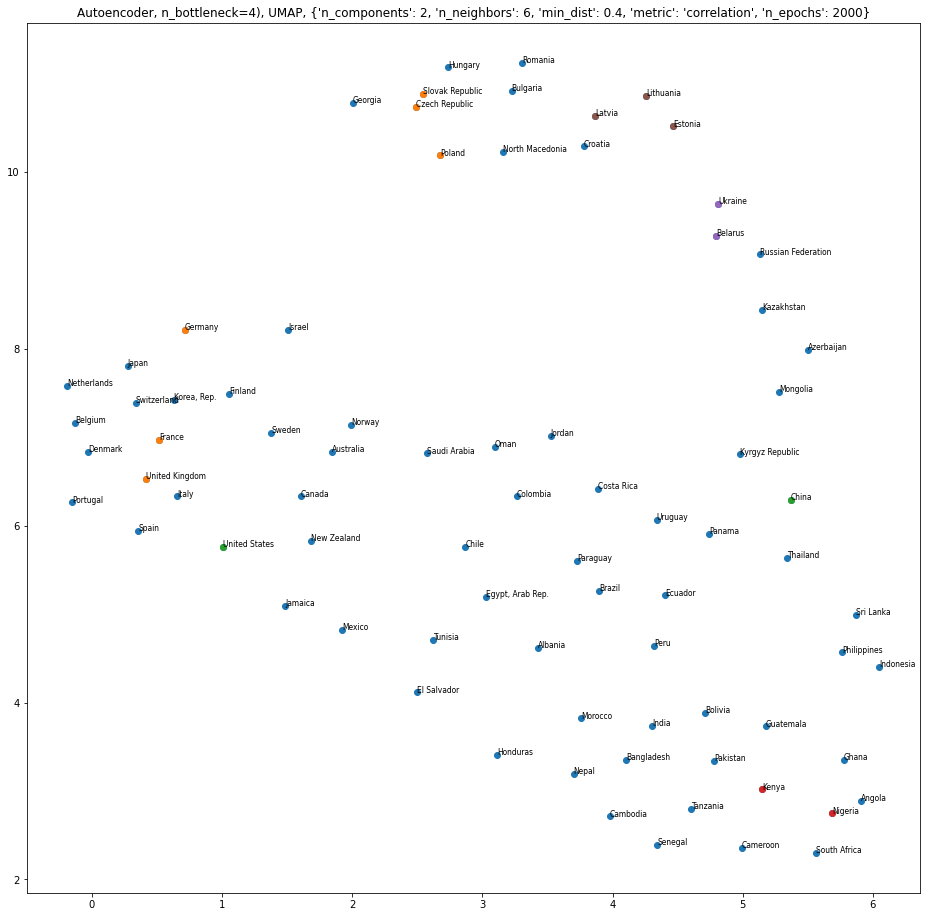

In [14]:
process_group(time_series_dict)